## **Image Classification with Transfer Learning (TensorFlow Hub)**

### **Getting great results with 10% of the data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip uninstall keras -y
! pip uninstall tensorflow -y

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [3]:
! pip install tensorflow==2.13.0 tensorflow-hub==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.3/90.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      Successfully uninstalled gast-0.6.0
  Attempting uninstall: tensorflow

In [1]:
import os
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import math
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, Activation
from tensorflow.keras.models import Sequential

### **Data Exploration**

In [2]:
dataset_path = Path("/content/drive/MyDrive/Dataset/10_food_classes_10_percent")

In [3]:
def display_structure(path, indent=0):
    for item in sorted(path.iterdir()):
        if item.is_dir():
            print(' ' * indent + '└───' + item.name)
            display_structure(item, indent + 4)

print("Dataset Structure:")
display_structure(dataset_path)

Dataset Structure:
└───test
    └───chicken_curry
    └───chicken_wings
    └───fried_rice
    └───grilled_salmon
    └───hamburger
    └───ice_cream
    └───pizza
    └───ramen
    └───steak
    └───sushi
└───train
    └───chicken_curry
    └───chicken_wings
    └───fried_rice
    └───grilled_salmon
    └───hamburger
    └───ice_cream
    └───pizza
    └───ramen
    └───steak
    └───sushi


In [4]:
train_path = dataset_path / "train"
test_path = dataset_path / "test"

In [ ]:
def count_images(path):
    counts = {}
    for subfolder in sorted(path.iterdir()):
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob("*.jpg")))
    return counts

train_counts = count_images(train_path)
test_counts = count_images(test_path)

print("Number of images in Train folder:", train_counts)
print("Number of images in Test folder:", test_counts)

Number of images in Train folder: {'chicken_curry': 75, 'chicken_wings': 75, 'fried_rice': 75, 'grilled_salmon': 75, 'hamburger': 75, 'ice_cream': 75, 'pizza': 75, 'ramen': 75, 'steak': 75, 'sushi': 75}
Number of images in Test folder: {'chicken_curry': 250, 'chicken_wings': 250, 'fried_rice': 250, 'grilled_salmon': 250, 'hamburger': 250, 'ice_cream': 250, 'pizza': 250, 'ramen': 250, 'steak': 250, 'sushi': 250}


In [ ]:
def show_sample_images_with_labels_and_shape(class_name, folder_path, num_images=5):
    images = list(folder_path.glob(f"{class_name}/*.jpg"))
    random_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random_images):
        img = mpimg.imread(img_path)
        img_shape = img.shape
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {class_name}\nShape: {img_shape}")
    plt.show()

show_sample_images_with_labels_and_shape("chicken_curry", train_path)
show_sample_images_with_labels_and_shape("chicken_wings", train_path)
show_sample_images_with_labels_and_shape("fried_rice", train_path)
show_sample_images_with_labels_and_shape("grilled_salmon", train_path)
show_sample_images_with_labels_and_shape("hamburger", train_path)
show_sample_images_with_labels_and_shape("ice_cream", train_path)
show_sample_images_with_labels_and_shape("pizza", train_path)
show_sample_images_with_labels_and_shape("ramen", train_path)
show_sample_images_with_labels_and_shape("steak", train_path)
show_sample_images_with_labels_and_shape("sushi", train_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def check_image_dimensions(folder_path):
    dimensions = []
    for image_path in folder_path.glob("*/*.jpg"):
        with Image.open(image_path) as img:
            dimensions.append(img.size)
    return dimensions

train_dimensions = check_image_dimensions(train_path)

unique_dimensions = set(train_dimensions)
print("Unique dimensions in training set:", unique_dimensions)

Unique dimensions in training set: {(512, 342), (512, 461), (341, 512), (512, 287), (385, 512), (508, 512), (512, 290), (512, 354), (512, 308), (512, 491), (288, 512), (512, 314), (512, 384), (512, 262), (512, 509), (512, 512), (382, 512), (391, 512), (512, 341), (512, 289), (512, 353), (512, 304), (307, 512), (512, 307), (384, 512), (512, 377), (342, 512), (289, 512), (512, 383), (512, 334), (512, 273), (512, 511), (512, 343), (512, 462), (512, 340), (512, 407), (512, 410), (509, 512), (512, 288), (511, 512), (512, 306), (512, 364), (306, 512), (512, 318), (512, 376), (512, 382), (512, 339), (383, 512)}


       ramen  pizza  steak  grilled_salmon  sushi  hamburger  ice_cream  \
Train     75     75     75              75     75         75         75   
Test     250    250    250             250    250        250        250   

       fried_rice  chicken_wings  chicken_curry  
Train          75             75             75  
Test          250            250            250  


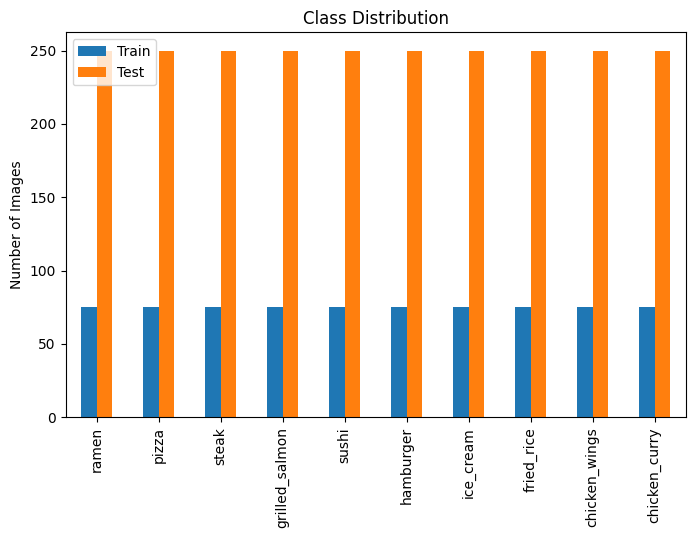

In [ ]:
def count_images_per_class(folder_path):
    counts = {}
    for subfolder in folder_path.iterdir():
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob("*.jpg")))
    return counts

train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

df = pd.DataFrame([train_counts, test_counts], index=["Train", "Test"])
print(df)

df.T.plot(kind="bar", figsize=(8, 5), title="Class Distribution")
plt.ylabel("Number of Images")
plt.show()

### **Data Preparation**

In [5]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_path,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_path,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### **📈 Experiment Tracking Setup**
**Purpose:**

1.   Create TensorBoard callback for tracking training metrics
2.   Organize logs by timestamped experiments
3.   Enable performance comparison between models

In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### **🤖 Model Configuration**

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  model = Sequential([
    feature_extractor_layer,
    Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### **ResNet50V2 Training**

In [9]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250202-054241
Epoch 1/5
24/24 [==============================] - 3077s 132s/step - loss: 2.1410 - accuracy: 0.2907 - val_loss: 1.2786 - val_accuracy: 0.6004
Epoch 2/5
24/24 [==============================] - 333s 14s/step - loss: 0.9944 - accuracy: 0.7053 - val_loss: 0.8690 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 308s 13s/step - loss: 0.6641 - accuracy: 0.8187 - val_loss: 0.7640 - val_accuracy: 0.7540
Epoch 4/5
24/24 [==============================] - 305s 13s/step - loss: 0.5158 - accuracy: 0.8707 - val_loss: 0.7147 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 334s 14s/step - loss: 0.4120 - accuracy: 0.9067 - val_loss: 0.6960 - val_accuracy: 0.7700


In [10]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

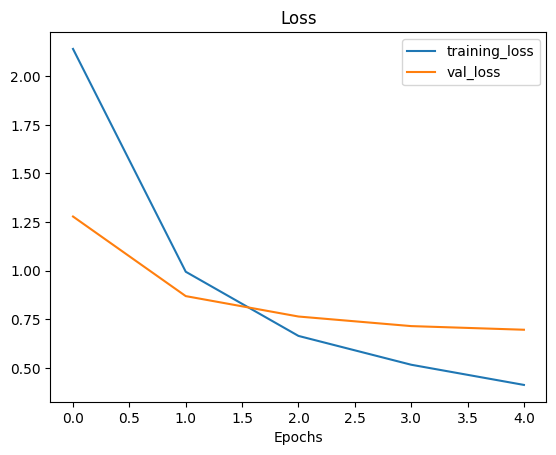

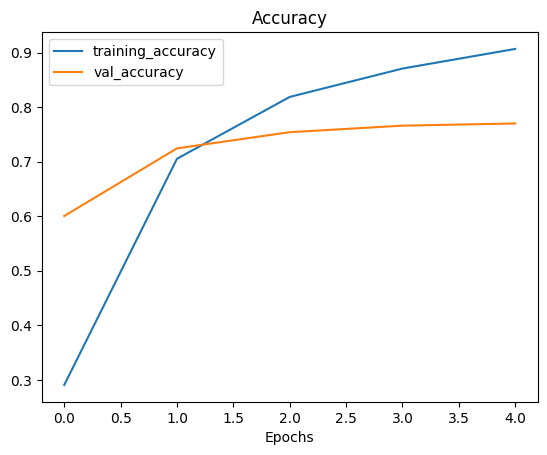

In [11]:
plot_loss_curves(resnet_history)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


### **EfficientNetB0 Training**

In [13]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              validation_data=test_data,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20250202-065805
Epoch 1/5
24/24 [==============================] - 256s 11s/step - loss: 1.8788 - accuracy: 0.4000 - val_loss: 1.3067 - val_accuracy: 0.7344
Epoch 2/5
24/24 [==============================] - 246s 11s/step - loss: 1.0790 - accuracy: 0.7747 - val_loss: 0.8652 - val_accuracy: 0.8248
Epoch 3/5
24/24 [==============================] - 191s 8s/step - loss: 0.7618 - accuracy: 0.8400 - val_loss: 0.6939 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 246s 11s/step - loss: 0.6112 - accuracy: 0.8747 - val_loss: 0.6081 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 191s 8s/step - loss: 0.5173 - accuracy: 0.8933 - val_loss: 0.5577 - val_accuracy: 0.8628


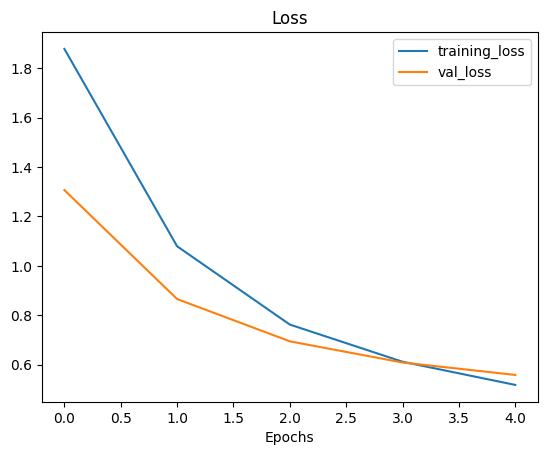

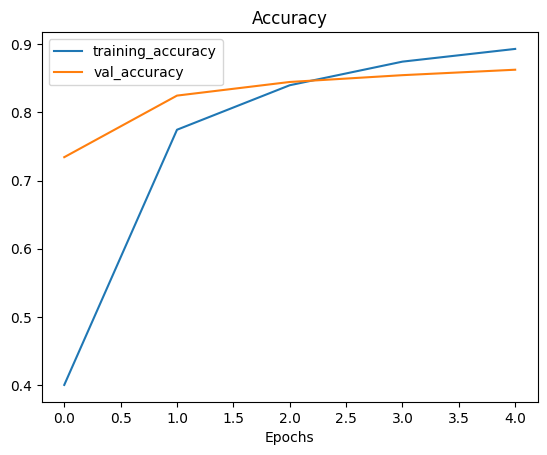

In [14]:
plot_loss_curves(efficientnet_history)

In [15]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


### **Comparing models using TensorBoard**

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot